In [ ]:
# Imports
import numpy as np
import pandas as pd
import os
from utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline    


/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#加载原始数据
raw_data = pd.read_csv(r"./newdata.csv", encoding='utf-8')
data = raw_data.fillna(0)
features_data = (data.drop(['label0', 'label10'],axis=1))
#5-class
target = data.label10
X = features_data.values.astype(np.float32) # 转换数据类型
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.30, random_state=123) # 参数test_size设置训练集占比
print(y_test)

print(one_hot(0, 4))
print(one_hot(1, 4))
print(one_hot(2, 4))
print(one_hot(3, 4))

965     3
209     1
913     3
1076    3
969     3
870     3
103     3
776     0
800     3
210     1
190     3
1013    3
688     3
261     3
835     3
690     1
754     3
891     1
529     3
13      3
916     3
859     3
68      1
200     3
694     0
244     3
906     3
147     3
991     3
448     3
       ..
298     1
185     3
316     3
372     1
151     3
807     3
912     1
981     3
780     3
783     3
1048    0
756     3
708     0
78      0
603     3
582     3
599     3
195     3
79      3
532     3
684     3
947     3
478     3
429     0
369     3
91      0
170     0
272     1
75      3
453     3
Name: label10, Length: 324, dtype: int64
[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


In [17]:
#Normalization
from sklearn import preprocessing
# l2正则化
X_train = preprocessing.normalize(X, norm='l2')
X_test = preprocessing.normalize(X_test, norm='l2')
print(X_train[0])
print(X_test.shape)


[9.9987727e-01 1.0529347e-04 1.5503003e-02 4.4294295e-04 0.0000000e+00
 0.0000000e+00 2.2147147e-03 0.0000000e+00 0.0000000e+00]
(324, 9)


In [4]:
#对分类进行one-hot编码
y_tr = one_hot(y_train.astype(np.int64),4)
y_vld = one_hot(y_test.astype(np.int64),4)
print(X_train.shape)
print(X_test.shape)
print("train num:", len(y_tr), y_tr.shape)
print("val num:", len(y_vld), y_vld.shape)
print("val:", np.array(y_vld))
print("val_source:", y_test)

(755, 9)
(324, 9)
train num: 755 (755, 4)
val num: 324 (324, 4)
val: [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
val_source: 965     3
209     1
913     3
1076    3
969     3
870     3
103     3
776     0
800     3
210     1
190     3
1013    3
688     3
261     3
835     3
690     1
754     3
891     1
529     3
13      3
916     3
859     3
68      1
200     3
694     0
244     3
906     3
147     3
991     3
448     3
       ..
298     1
185     3
316     3
372     1
151     3
807     3
912     1
981     3
780     3
783     3
1048    0
756     3
708     0
78      0
603     3
582     3
599     3
195     3
79      3
532     3
684     3
947     3
478     3
429     0
369     3
91      0
170     0
272     1
75      3
453     3
Name: label10, Length: 324, dtype: int64


In [5]:
import tensorflow as tf

#设置相关参数
batch_size = 755     # Batch size
features_num = 9        # Number of steps
learning_rate = 0.005   #0.003
epochs = 10000
n_classes = 4
lambda1 = 0.0001
log_dir = r'./logs'    # 输出日志保存的路径

In [6]:
graph = tf.Graph()
# Construct placeholders
with graph.as_default():
    in_units = 9
    h1_units = 50
    h2_units = 20
    
    #第一层全连接层参数
    W1 = tf.Variable(tf.truncated_normal([in_units, h1_units], stddev=0.1))
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(W1))
    b1 = tf.Variable(tf.zeros([h1_units]))
        
    W2 = tf.Variable(tf.truncated_normal([h1_units, h2_units], stddev=0.1))
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(W2))
    b2 = tf.Variable(tf.zeros([h2_units]))
    
    W3 = tf.Variable(tf.zeros([h2_units, n_classes]))
    #tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(W3))
    b3 = tf.Variable(tf.zeros([n_classes]))
    
    #构造网络
    inputs_ = tf.placeholder(tf.float32, [None, 9], name = 'inputs')
    print(inputs_)
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'prob')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    #第一层全连接层，将维度拓展到10
    hidden1 = tf.nn.relu(tf.matmul(inputs_, W1) + b1)
    
    hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2)
         
    #第二层全连接层，维度转换为5，进行5分类
    output_ = tf.matmul(hidden2, W3) + b3
    
    # Cost function and optimizer
    #二次代价函数，计算预测值与真实值之间的误差代价值-loss，其中第一个参数logits为最后一层输出，第二个为训练目标值即分类值
    #先通过Softmax函数，输出X对应输出每一类的概率大小，其次和真实值进行“交叉熵”，最终，对向量求均值，得到代价loss
    
    output_ = tf.nn.softmax(output_)
    cost = tf.reduce_mean(-tf.reduce_sum(labels_*tf.log(output_+1e-6), reduction_indices=[1]))
    
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_, labels=labels_))
    tf.add_to_collection('losses', cost)
    cost = tf.add_n(tf.get_collection('losses'))
    
    #梯度下降法，数据量选择AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    #correct_pred 返回一个布尔型数组，通过转化为0-1值后来计算准确率
    correct_pred = tf.equal(tf.argmax(output_, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    #预测值
    pred = tf.argmax(output_, 1,name='pred')
    #正确值
    label = tf.argmax(labels_, 1)

tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar('loss_function', cost)

Tensor("inputs:0", shape=(?, 9), dtype=float32)


<tf.Tensor 'loss_function:0' shape=() dtype=string>

In [7]:
if (os.path.exists(r'./checkpoints') == False):
    !mkdir checkpoints
    

In [8]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    # summaries合并
    merged = tf.summary.merge_all()    
    # 写到指定的磁盘路径中
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    # Loop over epochs
    for e in range(epochs):
        # Loop over batches
        for x, y in get_batches(X_train, y_tr, batch_size):
            x = x.reshape((batch_size,features_num))
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y,keep_prob_ : 0.80, learning_rate_ : learning_rate}
             # Loss
            summary_str, loss, _ , acc = sess.run([merged, cost, optimizer, accuracy], feed_dict = feed)
         
            train_acc.append(acc)
            train_loss.append(loss)
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
                train_writer.add_summary(summary_str, e);
                
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                x_v = X_test.reshape(-1, features_num)
                y_v = y_vld
                feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0} 
                summary, loss_v, acc_v, pred_labels = sess.run([merged, cost, accuracy, pred], feed_dict = feed)                    
                val_acc_.append(acc_v)
                val_loss_.append(loss_v)
                    
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                test_writer.add_summary(summary, e);
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            if (iteration%1000 == 0):
                x_v = X_test.reshape(-1, features_num)
                y_v = y_vld
                feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0} 
                output = sess.run(output_, feed_dict = feed)
                print(np.array(output))
            # Iterate 
            iteration += 1    

    saver.save(sess,"checkpoints-cnn/creditGrade.ckpt")
    # 保存二进制模型
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['pred'])
    with tf.gfile.FastGFile(r'./pred-model.pb', mode='wb') as f:
        f.write(output_graph_def.SerializeToString())

Epoch: 4/10000 Iteration: 5 Train loss: 1.350032 Train acc: 0.733775
Epoch: 9/10000 Iteration: 10 Train loss: 1.237851 Train acc: 0.733775
Epoch: 9/10000 Iteration: 10 Validation loss: 1.206101 Validation acc: 0.725309
Epoch: 14/10000 Iteration: 15 Train loss: 1.012746 Train acc: 0.733775
Epoch: 19/10000 Iteration: 20 Train loss: 0.823627 Train acc: 0.733775
Epoch: 19/10000 Iteration: 20 Validation loss: 0.854465 Validation acc: 0.725309
Epoch: 24/10000 Iteration: 25 Train loss: 0.821732 Train acc: 0.733775
Epoch: 29/10000 Iteration: 30 Train loss: 0.754206 Train acc: 0.733775
Epoch: 29/10000 Iteration: 30 Validation loss: 0.789787 Validation acc: 0.725309
Epoch: 34/10000 Iteration: 35 Train loss: 0.752082 Train acc: 0.733775
Epoch: 39/10000 Iteration: 40 Train loss: 0.743747 Train acc: 0.733775
Epoch: 39/10000 Iteration: 40 Validation loss: 0.774292 Validation acc: 0.725309
Epoch: 44/10000 Iteration: 45 Train loss: 0.726871 Train acc: 0.733775
Epoch: 49/10000 Iteration: 50 Train loss:

Epoch: 389/10000 Iteration: 390 Train loss: 0.501282 Train acc: 0.802649
Epoch: 389/10000 Iteration: 390 Validation loss: 0.562945 Validation acc: 0.753086
Epoch: 394/10000 Iteration: 395 Train loss: 0.496602 Train acc: 0.803973
Epoch: 399/10000 Iteration: 400 Train loss: 0.495334 Train acc: 0.805298
Epoch: 399/10000 Iteration: 400 Validation loss: 0.552063 Validation acc: 0.750000
Epoch: 404/10000 Iteration: 405 Train loss: 0.491098 Train acc: 0.805298
Epoch: 409/10000 Iteration: 410 Train loss: 0.494388 Train acc: 0.807947
Epoch: 409/10000 Iteration: 410 Validation loss: 0.553471 Validation acc: 0.746914
Epoch: 414/10000 Iteration: 415 Train loss: 0.484718 Train acc: 0.809272
Epoch: 419/10000 Iteration: 420 Train loss: 0.485699 Train acc: 0.806623
Epoch: 419/10000 Iteration: 420 Validation loss: 0.537351 Validation acc: 0.753086
Epoch: 424/10000 Iteration: 425 Train loss: 0.482641 Train acc: 0.807947
Epoch: 429/10000 Iteration: 430 Train loss: 0.476299 Train acc: 0.811921
Epoch: 429/

Epoch: 779/10000 Iteration: 780 Validation loss: 0.390521 Validation acc: 0.870370
Epoch: 784/10000 Iteration: 785 Train loss: 0.366563 Train acc: 0.876821
Epoch: 789/10000 Iteration: 790 Train loss: 0.361313 Train acc: 0.879470
Epoch: 789/10000 Iteration: 790 Validation loss: 0.389762 Validation acc: 0.867284
Epoch: 794/10000 Iteration: 795 Train loss: 0.364152 Train acc: 0.879470
Epoch: 799/10000 Iteration: 800 Train loss: 0.359764 Train acc: 0.882119
Epoch: 799/10000 Iteration: 800 Validation loss: 0.387557 Validation acc: 0.873457
Epoch: 804/10000 Iteration: 805 Train loss: 0.361385 Train acc: 0.880795
Epoch: 809/10000 Iteration: 810 Train loss: 0.362000 Train acc: 0.880795
Epoch: 809/10000 Iteration: 810 Validation loss: 0.390671 Validation acc: 0.876543
Epoch: 814/10000 Iteration: 815 Train loss: 0.358983 Train acc: 0.880795
Epoch: 819/10000 Iteration: 820 Train loss: 0.357787 Train acc: 0.886093
Epoch: 819/10000 Iteration: 820 Validation loss: 0.386797 Validation acc: 0.873457
E

Epoch: 1154/10000 Iteration: 1155 Train loss: 0.325846 Train acc: 0.899338
Epoch: 1159/10000 Iteration: 1160 Train loss: 0.340646 Train acc: 0.883444
Epoch: 1159/10000 Iteration: 1160 Validation loss: 0.365185 Validation acc: 0.898148
Epoch: 1164/10000 Iteration: 1165 Train loss: 0.318880 Train acc: 0.898013
Epoch: 1169/10000 Iteration: 1170 Train loss: 0.333257 Train acc: 0.901987
Epoch: 1169/10000 Iteration: 1170 Validation loss: 0.366604 Validation acc: 0.867284
Epoch: 1174/10000 Iteration: 1175 Train loss: 0.317816 Train acc: 0.896689
Epoch: 1179/10000 Iteration: 1180 Train loss: 0.335839 Train acc: 0.879470
Epoch: 1179/10000 Iteration: 1180 Validation loss: 0.365472 Validation acc: 0.898148
Epoch: 1184/10000 Iteration: 1185 Train loss: 0.317132 Train acc: 0.896689
Epoch: 1189/10000 Iteration: 1190 Train loss: 0.326020 Train acc: 0.898013
Epoch: 1189/10000 Iteration: 1190 Validation loss: 0.358807 Validation acc: 0.870370
Epoch: 1194/10000 Iteration: 1195 Train loss: 0.317458 Train

Epoch: 1514/10000 Iteration: 1515 Train loss: 0.297763 Train acc: 0.909934
Epoch: 1519/10000 Iteration: 1520 Train loss: 0.295693 Train acc: 0.913907
Epoch: 1519/10000 Iteration: 1520 Validation loss: 0.329743 Validation acc: 0.901235
Epoch: 1524/10000 Iteration: 1525 Train loss: 0.296492 Train acc: 0.911258
Epoch: 1529/10000 Iteration: 1530 Train loss: 0.304187 Train acc: 0.913907
Epoch: 1529/10000 Iteration: 1530 Validation loss: 0.343457 Validation acc: 0.882716
Epoch: 1534/10000 Iteration: 1535 Train loss: 0.313235 Train acc: 0.896689
Epoch: 1539/10000 Iteration: 1540 Train loss: 0.297307 Train acc: 0.912583
Epoch: 1539/10000 Iteration: 1540 Validation loss: 0.336573 Validation acc: 0.907407
Epoch: 1544/10000 Iteration: 1545 Train loss: 0.317854 Train acc: 0.907285
Epoch: 1549/10000 Iteration: 1550 Train loss: 0.303409 Train acc: 0.908609
Epoch: 1549/10000 Iteration: 1550 Validation loss: 0.347860 Validation acc: 0.873457
Epoch: 1554/10000 Iteration: 1555 Train loss: 0.302700 Train

Epoch: 1874/10000 Iteration: 1875 Train loss: 0.288487 Train acc: 0.909934
Epoch: 1879/10000 Iteration: 1880 Train loss: 0.289508 Train acc: 0.916556
Epoch: 1879/10000 Iteration: 1880 Validation loss: 0.321239 Validation acc: 0.907407
Epoch: 1884/10000 Iteration: 1885 Train loss: 0.286554 Train acc: 0.917881
Epoch: 1889/10000 Iteration: 1890 Train loss: 0.296939 Train acc: 0.908609
Epoch: 1889/10000 Iteration: 1890 Validation loss: 0.325520 Validation acc: 0.910494
Epoch: 1894/10000 Iteration: 1895 Train loss: 0.294234 Train acc: 0.907285
Epoch: 1899/10000 Iteration: 1900 Train loss: 0.282911 Train acc: 0.917881
Epoch: 1899/10000 Iteration: 1900 Validation loss: 0.317898 Validation acc: 0.913580
Epoch: 1904/10000 Iteration: 1905 Train loss: 0.279704 Train acc: 0.919205
Epoch: 1909/10000 Iteration: 1910 Train loss: 0.291007 Train acc: 0.907285
Epoch: 1909/10000 Iteration: 1910 Validation loss: 0.329209 Validation acc: 0.907407
Epoch: 1914/10000 Iteration: 1915 Train loss: 0.278724 Train

Epoch: 2234/10000 Iteration: 2235 Train loss: 0.285805 Train acc: 0.901987
Epoch: 2239/10000 Iteration: 2240 Train loss: 0.269953 Train acc: 0.917881
Epoch: 2239/10000 Iteration: 2240 Validation loss: 0.310062 Validation acc: 0.910494
Epoch: 2244/10000 Iteration: 2245 Train loss: 0.281653 Train acc: 0.927152
Epoch: 2249/10000 Iteration: 2250 Train loss: 0.268511 Train acc: 0.920530
Epoch: 2249/10000 Iteration: 2250 Validation loss: 0.308651 Validation acc: 0.916667
Epoch: 2254/10000 Iteration: 2255 Train loss: 0.271585 Train acc: 0.919205
Epoch: 2259/10000 Iteration: 2260 Train loss: 0.276206 Train acc: 0.925828
Epoch: 2259/10000 Iteration: 2260 Validation loss: 0.316229 Validation acc: 0.904321
Epoch: 2264/10000 Iteration: 2265 Train loss: 0.265208 Train acc: 0.925828
Epoch: 2269/10000 Iteration: 2270 Train loss: 0.278565 Train acc: 0.909934
Epoch: 2269/10000 Iteration: 2270 Validation loss: 0.322142 Validation acc: 0.922840
Epoch: 2274/10000 Iteration: 2275 Train loss: 0.270239 Train

Epoch: 2594/10000 Iteration: 2595 Train loss: 0.270615 Train acc: 0.915232
Epoch: 2599/10000 Iteration: 2600 Train loss: 0.258682 Train acc: 0.927152
Epoch: 2599/10000 Iteration: 2600 Validation loss: 0.304572 Validation acc: 0.919753
Epoch: 2604/10000 Iteration: 2605 Train loss: 0.270958 Train acc: 0.931126
Epoch: 2609/10000 Iteration: 2610 Train loss: 0.255519 Train acc: 0.927152
Epoch: 2609/10000 Iteration: 2610 Validation loss: 0.297682 Validation acc: 0.919753
Epoch: 2614/10000 Iteration: 2615 Train loss: 0.272954 Train acc: 0.909934
Epoch: 2619/10000 Iteration: 2620 Train loss: 0.258374 Train acc: 0.924503
Epoch: 2619/10000 Iteration: 2620 Validation loss: 0.298877 Validation acc: 0.919753
Epoch: 2624/10000 Iteration: 2625 Train loss: 0.265079 Train acc: 0.931126
Epoch: 2629/10000 Iteration: 2630 Train loss: 0.267011 Train acc: 0.920530
Epoch: 2629/10000 Iteration: 2630 Validation loss: 0.304294 Validation acc: 0.913580
Epoch: 2634/10000 Iteration: 2635 Train loss: 0.264520 Train

Epoch: 2954/10000 Iteration: 2955 Train loss: 0.260723 Train acc: 0.919205
Epoch: 2959/10000 Iteration: 2960 Train loss: 0.257206 Train acc: 0.921854
Epoch: 2959/10000 Iteration: 2960 Validation loss: 0.302948 Validation acc: 0.925926
Epoch: 2964/10000 Iteration: 2965 Train loss: 0.260476 Train acc: 0.931126
Epoch: 2969/10000 Iteration: 2970 Train loss: 0.249712 Train acc: 0.931126
Epoch: 2969/10000 Iteration: 2970 Validation loss: 0.294529 Validation acc: 0.919753
Epoch: 2974/10000 Iteration: 2975 Train loss: 0.268576 Train acc: 0.912583
Epoch: 2979/10000 Iteration: 2980 Train loss: 0.247042 Train acc: 0.932450
Epoch: 2979/10000 Iteration: 2980 Validation loss: 0.293281 Validation acc: 0.922840
Epoch: 2984/10000 Iteration: 2985 Train loss: 0.261274 Train acc: 0.932450
Epoch: 2989/10000 Iteration: 2990 Train loss: 0.252702 Train acc: 0.927152
Epoch: 2989/10000 Iteration: 2990 Validation loss: 0.292882 Validation acc: 0.919753
Epoch: 2994/10000 Iteration: 2995 Train loss: 0.259474 Train

Epoch: 3314/10000 Iteration: 3315 Train loss: 0.258582 Train acc: 0.917881
Epoch: 3319/10000 Iteration: 3320 Train loss: 0.241311 Train acc: 0.941722
Epoch: 3319/10000 Iteration: 3320 Validation loss: 0.288080 Validation acc: 0.925926
Epoch: 3324/10000 Iteration: 3325 Train loss: 0.255319 Train acc: 0.933775
Epoch: 3329/10000 Iteration: 3330 Train loss: 0.241690 Train acc: 0.937748
Epoch: 3329/10000 Iteration: 3330 Validation loss: 0.286270 Validation acc: 0.925926
Epoch: 3334/10000 Iteration: 3335 Train loss: 0.258411 Train acc: 0.915232
Epoch: 3339/10000 Iteration: 3340 Train loss: 0.247978 Train acc: 0.929801
Epoch: 3339/10000 Iteration: 3340 Validation loss: 0.286980 Validation acc: 0.922840
Epoch: 3344/10000 Iteration: 3345 Train loss: 0.253297 Train acc: 0.933775
Epoch: 3349/10000 Iteration: 3350 Train loss: 0.250498 Train acc: 0.927152
Epoch: 3349/10000 Iteration: 3350 Validation loss: 0.290712 Validation acc: 0.925926
Epoch: 3354/10000 Iteration: 3355 Train loss: 0.244127 Train

Epoch: 3679/10000 Iteration: 3680 Train loss: 0.243882 Train acc: 0.933775
Epoch: 3679/10000 Iteration: 3680 Validation loss: 0.284634 Validation acc: 0.925926
Epoch: 3684/10000 Iteration: 3685 Train loss: 0.240658 Train acc: 0.937748
Epoch: 3689/10000 Iteration: 3690 Train loss: 0.265230 Train acc: 0.909934
Epoch: 3689/10000 Iteration: 3690 Validation loss: 0.295816 Validation acc: 0.922840
Epoch: 3694/10000 Iteration: 3695 Train loss: 0.243417 Train acc: 0.935099
Epoch: 3699/10000 Iteration: 3700 Train loss: 0.246929 Train acc: 0.935099
Epoch: 3699/10000 Iteration: 3700 Validation loss: 0.288873 Validation acc: 0.919753
Epoch: 3704/10000 Iteration: 3705 Train loss: 0.235499 Train acc: 0.939073
Epoch: 3709/10000 Iteration: 3710 Train loss: 0.256546 Train acc: 0.916556
Epoch: 3709/10000 Iteration: 3710 Validation loss: 0.297703 Validation acc: 0.922840
Epoch: 3714/10000 Iteration: 3715 Train loss: 0.234174 Train acc: 0.937748
Epoch: 3719/10000 Iteration: 3720 Train loss: 0.247892 Train

Epoch: 4039/10000 Iteration: 4040 Train loss: 0.228540 Train acc: 0.936424
Epoch: 4039/10000 Iteration: 4040 Validation loss: 0.279052 Validation acc: 0.932099
Epoch: 4044/10000 Iteration: 4045 Train loss: 0.246945 Train acc: 0.940397
Epoch: 4049/10000 Iteration: 4050 Train loss: 0.229476 Train acc: 0.937748
Epoch: 4049/10000 Iteration: 4050 Validation loss: 0.278008 Validation acc: 0.925926
Epoch: 4054/10000 Iteration: 4055 Train loss: 0.251917 Train acc: 0.916556
Epoch: 4059/10000 Iteration: 4060 Train loss: 0.231800 Train acc: 0.936424
Epoch: 4059/10000 Iteration: 4060 Validation loss: 0.277606 Validation acc: 0.925926
Epoch: 4064/10000 Iteration: 4065 Train loss: 0.239141 Train acc: 0.940397
Epoch: 4069/10000 Iteration: 4070 Train loss: 0.242403 Train acc: 0.928477
Epoch: 4069/10000 Iteration: 4070 Validation loss: 0.283280 Validation acc: 0.929012
Epoch: 4074/10000 Iteration: 4075 Train loss: 0.238443 Train acc: 0.932450
Epoch: 4079/10000 Iteration: 4080 Train loss: 0.244162 Train

Epoch: 4404/10000 Iteration: 4405 Train loss: 0.235626 Train acc: 0.932450
Epoch: 4409/10000 Iteration: 4410 Train loss: 0.236898 Train acc: 0.941722
Epoch: 4409/10000 Iteration: 4410 Validation loss: 0.282793 Validation acc: 0.925926
Epoch: 4414/10000 Iteration: 4415 Train loss: 0.225784 Train acc: 0.941722
Epoch: 4419/10000 Iteration: 4420 Train loss: 0.254158 Train acc: 0.913907
Epoch: 4419/10000 Iteration: 4420 Validation loss: 0.292366 Validation acc: 0.916667
Epoch: 4424/10000 Iteration: 4425 Train loss: 0.224601 Train acc: 0.940397
Epoch: 4429/10000 Iteration: 4430 Train loss: 0.244706 Train acc: 0.940397
Epoch: 4429/10000 Iteration: 4430 Validation loss: 0.297321 Validation acc: 0.910494
Epoch: 4434/10000 Iteration: 4435 Train loss: 0.223358 Train acc: 0.944371
Epoch: 4439/10000 Iteration: 4440 Train loss: 0.247208 Train acc: 0.919205
Epoch: 4439/10000 Iteration: 4440 Validation loss: 0.288809 Validation acc: 0.922840
Epoch: 4444/10000 Iteration: 4445 Train loss: 0.225078 Train

Epoch: 4769/10000 Iteration: 4770 Train loss: 0.245152 Train acc: 0.917881
Epoch: 4769/10000 Iteration: 4770 Validation loss: 0.289930 Validation acc: 0.925926
Epoch: 4774/10000 Iteration: 4775 Train loss: 0.224008 Train acc: 0.939073
Epoch: 4779/10000 Iteration: 4780 Train loss: 0.235765 Train acc: 0.943046
Epoch: 4779/10000 Iteration: 4780 Validation loss: 0.290906 Validation acc: 0.913580
Epoch: 4784/10000 Iteration: 4785 Train loss: 0.226627 Train acc: 0.943046
Epoch: 4789/10000 Iteration: 4790 Train loss: 0.224773 Train acc: 0.944371
Epoch: 4789/10000 Iteration: 4790 Validation loss: 0.276771 Validation acc: 0.935185
Epoch: 4794/10000 Iteration: 4795 Train loss: 0.237574 Train acc: 0.941722
Epoch: 4799/10000 Iteration: 4800 Train loss: 0.219497 Train acc: 0.944371
Epoch: 4799/10000 Iteration: 4800 Validation loss: 0.273894 Validation acc: 0.925926
Epoch: 4804/10000 Iteration: 4805 Train loss: 0.255817 Train acc: 0.907285
Epoch: 4809/10000 Iteration: 4810 Train loss: 0.219803 Train

Epoch: 5129/10000 Iteration: 5130 Train loss: 0.216548 Train acc: 0.944371
Epoch: 5129/10000 Iteration: 5130 Validation loss: 0.272292 Validation acc: 0.929012
Epoch: 5134/10000 Iteration: 5135 Train loss: 0.242332 Train acc: 0.920530
Epoch: 5139/10000 Iteration: 5140 Train loss: 0.215953 Train acc: 0.943046
Epoch: 5139/10000 Iteration: 5140 Validation loss: 0.270333 Validation acc: 0.932099
Epoch: 5144/10000 Iteration: 5145 Train loss: 0.238532 Train acc: 0.939073
Epoch: 5149/10000 Iteration: 5150 Train loss: 0.216073 Train acc: 0.940397
Epoch: 5149/10000 Iteration: 5150 Validation loss: 0.272395 Validation acc: 0.935185
Epoch: 5154/10000 Iteration: 5155 Train loss: 0.241106 Train acc: 0.923179
Epoch: 5159/10000 Iteration: 5160 Train loss: 0.218434 Train acc: 0.941722
Epoch: 5159/10000 Iteration: 5160 Validation loss: 0.269661 Validation acc: 0.935185
Epoch: 5164/10000 Iteration: 5165 Train loss: 0.221737 Train acc: 0.947020
Epoch: 5169/10000 Iteration: 5170 Train loss: 0.245049 Train

Epoch: 5489/10000 Iteration: 5490 Train loss: 0.211811 Train acc: 0.945695
Epoch: 5489/10000 Iteration: 5490 Validation loss: 0.272715 Validation acc: 0.935185
Epoch: 5494/10000 Iteration: 5495 Train loss: 0.240130 Train acc: 0.941722
Epoch: 5499/10000 Iteration: 5500 Train loss: 0.212812 Train acc: 0.944371
Epoch: 5499/10000 Iteration: 5500 Validation loss: 0.276812 Validation acc: 0.916667
Epoch: 5504/10000 Iteration: 5505 Train loss: 0.238273 Train acc: 0.924503
Epoch: 5509/10000 Iteration: 5510 Train loss: 0.212214 Train acc: 0.944371
Epoch: 5509/10000 Iteration: 5510 Validation loss: 0.268664 Validation acc: 0.932099
Epoch: 5514/10000 Iteration: 5515 Train loss: 0.219085 Train acc: 0.948344
Epoch: 5519/10000 Iteration: 5520 Train loss: 0.235362 Train acc: 0.928477
Epoch: 5519/10000 Iteration: 5520 Validation loss: 0.278452 Validation acc: 0.935185
Epoch: 5524/10000 Iteration: 5525 Train loss: 0.219275 Train acc: 0.943046
Epoch: 5529/10000 Iteration: 5530 Train loss: 0.235342 Train

Epoch: 5849/10000 Iteration: 5850 Train loss: 0.219645 Train acc: 0.943046
Epoch: 5849/10000 Iteration: 5850 Validation loss: 0.268243 Validation acc: 0.935185
Epoch: 5854/10000 Iteration: 5855 Train loss: 0.231665 Train acc: 0.928477
Epoch: 5859/10000 Iteration: 5860 Train loss: 0.217782 Train acc: 0.944371
Epoch: 5859/10000 Iteration: 5860 Validation loss: 0.269769 Validation acc: 0.935185
Epoch: 5864/10000 Iteration: 5865 Train loss: 0.227246 Train acc: 0.943046
Epoch: 5869/10000 Iteration: 5870 Train loss: 0.216124 Train acc: 0.944371
Epoch: 5869/10000 Iteration: 5870 Validation loss: 0.270576 Validation acc: 0.935185
Epoch: 5874/10000 Iteration: 5875 Train loss: 0.212521 Train acc: 0.947020
Epoch: 5879/10000 Iteration: 5880 Train loss: 0.229141 Train acc: 0.943046
Epoch: 5879/10000 Iteration: 5880 Validation loss: 0.293323 Validation acc: 0.913580
Epoch: 5884/10000 Iteration: 5885 Train loss: 0.208409 Train acc: 0.947020
Epoch: 5889/10000 Iteration: 5890 Train loss: 0.252380 Train

Epoch: 6209/10000 Iteration: 6210 Train loss: 0.216927 Train acc: 0.949669
Epoch: 6209/10000 Iteration: 6210 Validation loss: 0.283604 Validation acc: 0.922840
Epoch: 6214/10000 Iteration: 6215 Train loss: 0.224345 Train acc: 0.935099
Epoch: 6219/10000 Iteration: 6220 Train loss: 0.220561 Train acc: 0.937748
Epoch: 6219/10000 Iteration: 6220 Validation loss: 0.279407 Validation acc: 0.938272
Epoch: 6224/10000 Iteration: 6225 Train loss: 0.223431 Train acc: 0.944371
Epoch: 6229/10000 Iteration: 6230 Train loss: 0.228392 Train acc: 0.944371
Epoch: 6229/10000 Iteration: 6230 Validation loss: 0.297532 Validation acc: 0.910494
Epoch: 6234/10000 Iteration: 6235 Train loss: 0.206612 Train acc: 0.950993
Epoch: 6239/10000 Iteration: 6240 Train loss: 0.222913 Train acc: 0.940397
Epoch: 6239/10000 Iteration: 6240 Validation loss: 0.276364 Validation acc: 0.935185
Epoch: 6244/10000 Iteration: 6245 Train loss: 0.210920 Train acc: 0.947020
Epoch: 6249/10000 Iteration: 6250 Train loss: 0.205488 Train

Epoch: 6569/10000 Iteration: 6570 Train loss: 0.224862 Train acc: 0.936424
Epoch: 6569/10000 Iteration: 6570 Validation loss: 0.274948 Validation acc: 0.935185
Epoch: 6574/10000 Iteration: 6575 Train loss: 0.208867 Train acc: 0.947020
Epoch: 6579/10000 Iteration: 6580 Train loss: 0.202408 Train acc: 0.952318
Epoch: 6579/10000 Iteration: 6580 Validation loss: 0.261120 Validation acc: 0.932099
Epoch: 6584/10000 Iteration: 6585 Train loss: 0.220537 Train acc: 0.937748
Epoch: 6589/10000 Iteration: 6590 Train loss: 0.211812 Train acc: 0.947020
Epoch: 6589/10000 Iteration: 6590 Validation loss: 0.262112 Validation acc: 0.938272
Epoch: 6594/10000 Iteration: 6595 Train loss: 0.217170 Train acc: 0.949669
Epoch: 6599/10000 Iteration: 6600 Train loss: 0.220522 Train acc: 0.937748
Epoch: 6599/10000 Iteration: 6600 Validation loss: 0.265581 Validation acc: 0.935185
Epoch: 6604/10000 Iteration: 6605 Train loss: 0.245398 Train acc: 0.913907
Epoch: 6609/10000 Iteration: 6610 Train loss: 0.202483 Train

Epoch: 6934/10000 Iteration: 6935 Train loss: 0.255326 Train acc: 0.908609
Epoch: 6939/10000 Iteration: 6940 Train loss: 0.223327 Train acc: 0.925828
Epoch: 6939/10000 Iteration: 6940 Validation loss: 0.282206 Validation acc: 0.935185
Epoch: 6944/10000 Iteration: 6945 Train loss: 0.206239 Train acc: 0.952318
Epoch: 6949/10000 Iteration: 6950 Train loss: 0.217955 Train acc: 0.945695
Epoch: 6949/10000 Iteration: 6950 Validation loss: 0.281242 Validation acc: 0.922840
Epoch: 6954/10000 Iteration: 6955 Train loss: 0.200476 Train acc: 0.954967
Epoch: 6959/10000 Iteration: 6960 Train loss: 0.210840 Train acc: 0.944371
Epoch: 6959/10000 Iteration: 6960 Validation loss: 0.270378 Validation acc: 0.935185
Epoch: 6964/10000 Iteration: 6965 Train loss: 0.220349 Train acc: 0.947020
Epoch: 6969/10000 Iteration: 6970 Train loss: 0.209986 Train acc: 0.952318
Epoch: 6969/10000 Iteration: 6970 Validation loss: 0.281314 Validation acc: 0.916667
Epoch: 6974/10000 Iteration: 6975 Train loss: 0.225939 Train

Epoch: 7309/10000 Iteration: 7310 Validation loss: 0.261994 Validation acc: 0.935185
Epoch: 7314/10000 Iteration: 7315 Train loss: 0.232927 Train acc: 0.947020
Epoch: 7319/10000 Iteration: 7320 Train loss: 0.200884 Train acc: 0.949669
Epoch: 7319/10000 Iteration: 7320 Validation loss: 0.280722 Validation acc: 0.919753
Epoch: 7324/10000 Iteration: 7325 Train loss: 0.211748 Train acc: 0.945695
Epoch: 7329/10000 Iteration: 7330 Train loss: 0.279788 Train acc: 0.899338
Epoch: 7329/10000 Iteration: 7330 Validation loss: 0.286344 Validation acc: 0.925926
Epoch: 7334/10000 Iteration: 7335 Train loss: 0.239326 Train acc: 0.916556
Epoch: 7339/10000 Iteration: 7340 Train loss: 0.203268 Train acc: 0.949669
Epoch: 7339/10000 Iteration: 7340 Validation loss: 0.279234 Validation acc: 0.932099
Epoch: 7344/10000 Iteration: 7345 Train loss: 0.210155 Train acc: 0.947020
Epoch: 7349/10000 Iteration: 7350 Train loss: 0.223662 Train acc: 0.949669
Epoch: 7349/10000 Iteration: 7350 Validation loss: 0.267150 

Epoch: 7679/10000 Iteration: 7680 Validation loss: 0.283915 Validation acc: 0.929012
Epoch: 7684/10000 Iteration: 7685 Train loss: 0.200080 Train acc: 0.948344
Epoch: 7689/10000 Iteration: 7690 Train loss: 0.216364 Train acc: 0.945695
Epoch: 7689/10000 Iteration: 7690 Validation loss: 0.269249 Validation acc: 0.925926
Epoch: 7694/10000 Iteration: 7695 Train loss: 0.196014 Train acc: 0.950993
Epoch: 7699/10000 Iteration: 7700 Train loss: 0.215463 Train acc: 0.937748
Epoch: 7699/10000 Iteration: 7700 Validation loss: 0.273003 Validation acc: 0.938272
Epoch: 7704/10000 Iteration: 7705 Train loss: 0.202710 Train acc: 0.952318
Epoch: 7709/10000 Iteration: 7710 Train loss: 0.199373 Train acc: 0.953642
Epoch: 7709/10000 Iteration: 7710 Validation loss: 0.263739 Validation acc: 0.929012
Epoch: 7714/10000 Iteration: 7715 Train loss: 0.250763 Train acc: 0.909934
Epoch: 7719/10000 Iteration: 7720 Train loss: 0.218851 Train acc: 0.932450
Epoch: 7719/10000 Iteration: 7720 Validation loss: 0.280499 

Epoch: 8059/10000 Iteration: 8060 Validation loss: 0.254363 Validation acc: 0.935185
Epoch: 8064/10000 Iteration: 8065 Train loss: 0.211550 Train acc: 0.950993
Epoch: 8069/10000 Iteration: 8070 Train loss: 0.203676 Train acc: 0.948344
Epoch: 8069/10000 Iteration: 8070 Validation loss: 0.256927 Validation acc: 0.935185
Epoch: 8074/10000 Iteration: 8075 Train loss: 0.218527 Train acc: 0.935099
Epoch: 8079/10000 Iteration: 8080 Train loss: 0.204819 Train acc: 0.949669
Epoch: 8079/10000 Iteration: 8080 Validation loss: 0.260394 Validation acc: 0.922840
Epoch: 8084/10000 Iteration: 8085 Train loss: 0.197512 Train acc: 0.953642
Epoch: 8089/10000 Iteration: 8090 Train loss: 0.232705 Train acc: 0.916556
Epoch: 8089/10000 Iteration: 8090 Validation loss: 0.278241 Validation acc: 0.935185
Epoch: 8094/10000 Iteration: 8095 Train loss: 0.193306 Train acc: 0.953642
Epoch: 8099/10000 Iteration: 8100 Train loss: 0.216304 Train acc: 0.944371
Epoch: 8099/10000 Iteration: 8100 Validation loss: 0.280035 

Epoch: 8419/10000 Iteration: 8420 Train loss: 0.202985 Train acc: 0.949669
Epoch: 8419/10000 Iteration: 8420 Validation loss: 0.273611 Validation acc: 0.925926
Epoch: 8424/10000 Iteration: 8425 Train loss: 0.205165 Train acc: 0.945695
Epoch: 8429/10000 Iteration: 8430 Train loss: 0.193657 Train acc: 0.954967
Epoch: 8429/10000 Iteration: 8430 Validation loss: 0.255262 Validation acc: 0.932099
Epoch: 8434/10000 Iteration: 8435 Train loss: 0.229942 Train acc: 0.945695
Epoch: 8439/10000 Iteration: 8440 Train loss: 0.209811 Train acc: 0.952318
Epoch: 8439/10000 Iteration: 8440 Validation loss: 0.296334 Validation acc: 0.907407
Epoch: 8444/10000 Iteration: 8445 Train loss: 0.193682 Train acc: 0.954967
Epoch: 8449/10000 Iteration: 8450 Train loss: 0.211792 Train acc: 0.940397
Epoch: 8449/10000 Iteration: 8450 Validation loss: 0.272331 Validation acc: 0.941358
Epoch: 8454/10000 Iteration: 8455 Train loss: 0.196855 Train acc: 0.952318
Epoch: 8459/10000 Iteration: 8460 Train loss: 0.199260 Train

Epoch: 8784/10000 Iteration: 8785 Train loss: 0.199038 Train acc: 0.950993
Epoch: 8789/10000 Iteration: 8790 Train loss: 0.200488 Train acc: 0.953642
Epoch: 8789/10000 Iteration: 8790 Validation loss: 0.260622 Validation acc: 0.929012
Epoch: 8794/10000 Iteration: 8795 Train loss: 0.187946 Train acc: 0.960265
Epoch: 8799/10000 Iteration: 8800 Train loss: 0.189702 Train acc: 0.958940
Epoch: 8799/10000 Iteration: 8800 Validation loss: 0.253771 Validation acc: 0.938272
Epoch: 8804/10000 Iteration: 8805 Train loss: 0.207422 Train acc: 0.949669
Epoch: 8809/10000 Iteration: 8810 Train loss: 0.191988 Train acc: 0.953642
Epoch: 8809/10000 Iteration: 8810 Validation loss: 0.252213 Validation acc: 0.935185
Epoch: 8814/10000 Iteration: 8815 Train loss: 0.233132 Train acc: 0.913907
Epoch: 8819/10000 Iteration: 8820 Train loss: 0.190709 Train acc: 0.948344
Epoch: 8819/10000 Iteration: 8820 Validation loss: 0.261298 Validation acc: 0.935185
Epoch: 8824/10000 Iteration: 8825 Train loss: 0.210738 Train

Epoch: 9149/10000 Iteration: 9150 Train loss: 0.185638 Train acc: 0.961589
Epoch: 9149/10000 Iteration: 9150 Validation loss: 0.249236 Validation acc: 0.935185
Epoch: 9154/10000 Iteration: 9155 Train loss: 0.189617 Train acc: 0.956291
Epoch: 9159/10000 Iteration: 9160 Train loss: 0.213058 Train acc: 0.949669
Epoch: 9159/10000 Iteration: 9160 Validation loss: 0.282173 Validation acc: 0.916667
Epoch: 9164/10000 Iteration: 9165 Train loss: 0.185906 Train acc: 0.957616
Epoch: 9169/10000 Iteration: 9170 Train loss: 0.263037 Train acc: 0.901987
Epoch: 9169/10000 Iteration: 9170 Validation loss: 0.295206 Validation acc: 0.929012
Epoch: 9174/10000 Iteration: 9175 Train loss: 0.201160 Train acc: 0.944371
Epoch: 9179/10000 Iteration: 9180 Train loss: 0.188560 Train acc: 0.952318
Epoch: 9179/10000 Iteration: 9180 Validation loss: 0.246695 Validation acc: 0.935185
Epoch: 9184/10000 Iteration: 9185 Train loss: 0.243404 Train acc: 0.936424
Epoch: 9189/10000 Iteration: 9190 Train loss: 0.227705 Train

Epoch: 9534/10000 Iteration: 9535 Train loss: 0.189925 Train acc: 0.954967
Epoch: 9539/10000 Iteration: 9540 Train loss: 0.188180 Train acc: 0.958940
Epoch: 9539/10000 Iteration: 9540 Validation loss: 0.256156 Validation acc: 0.929012
Epoch: 9544/10000 Iteration: 9545 Train loss: 0.245733 Train acc: 0.909934
Epoch: 9549/10000 Iteration: 9550 Train loss: 0.193967 Train acc: 0.948344
Epoch: 9549/10000 Iteration: 9550 Validation loss: 0.268207 Validation acc: 0.941358
Epoch: 9554/10000 Iteration: 9555 Train loss: 0.209078 Train acc: 0.947020
Epoch: 9559/10000 Iteration: 9560 Train loss: 0.189958 Train acc: 0.954967
Epoch: 9559/10000 Iteration: 9560 Validation loss: 0.259481 Validation acc: 0.925926
Epoch: 9564/10000 Iteration: 9565 Train loss: 0.205447 Train acc: 0.941722
Epoch: 9569/10000 Iteration: 9570 Train loss: 0.188481 Train acc: 0.954967
Epoch: 9569/10000 Iteration: 9570 Validation loss: 0.250761 Validation acc: 0.932099
Epoch: 9574/10000 Iteration: 9575 Train loss: 0.187361 Train

Epoch: 9899/10000 Iteration: 9900 Train loss: 0.183682 Train acc: 0.956291
Epoch: 9899/10000 Iteration: 9900 Validation loss: 0.255476 Validation acc: 0.935185
Epoch: 9904/10000 Iteration: 9905 Train loss: 0.203675 Train acc: 0.952318
Epoch: 9909/10000 Iteration: 9910 Train loss: 0.194983 Train acc: 0.953642
Epoch: 9909/10000 Iteration: 9910 Validation loss: 0.255010 Validation acc: 0.935185
Epoch: 9914/10000 Iteration: 9915 Train loss: 0.185479 Train acc: 0.958940
Epoch: 9919/10000 Iteration: 9920 Train loss: 0.217999 Train acc: 0.948344
Epoch: 9919/10000 Iteration: 9920 Validation loss: 0.304564 Validation acc: 0.907407
Epoch: 9924/10000 Iteration: 9925 Train loss: 0.184974 Train acc: 0.950993
Epoch: 9929/10000 Iteration: 9930 Train loss: 0.224248 Train acc: 0.921854
Epoch: 9929/10000 Iteration: 9930 Validation loss: 0.258973 Validation acc: 0.941358
Epoch: 9934/10000 Iteration: 9935 Train loss: 0.187111 Train acc: 0.956291
Epoch: 9939/10000 Iteration: 9940 Train loss: 0.198937 Train

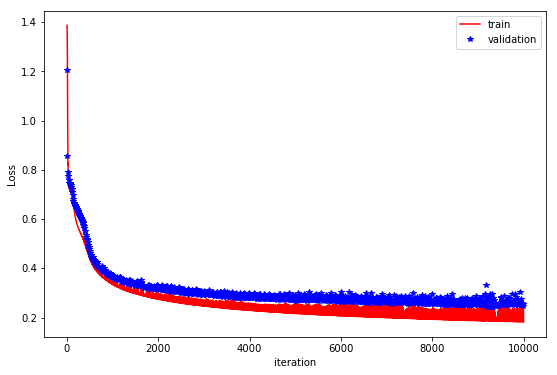

In [9]:
t = np.arange(iteration-1)
#print(np.array(train_loss))
plt.figure(figsize = (9,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

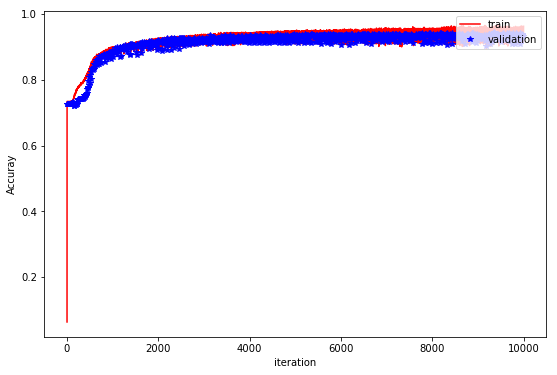

In [10]:
# Plot Accuracies
plt.figure(figsize = (9,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [14]:
test_acc = []
pred_labels = []
label = []
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    x_v = X_test.reshape(-1, features_num)
    y_v = y_vld
    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0} 
    batch_acc, preds, labels, output = sess.run([accuracy, pred, label, output_], feed_dict=feed)
    #preds = sess.run(pred, feed_dict=feed)
    #labels = sess.run(label, feed_dict=feed)
    #output = sess.run(output_, feed_dict=feed)
    #max_index = np.argmax(prediction)
    #print(max_index)
    test_acc.append(batch_acc)
    pred_labels.append(preds)
    label.append(labels)
    
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    print("pred value", pred_labels)
    print("ground value", np.array(y_test))

    print("input:", x_v[1])
    print("output:", np.array(output))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/creditGrade.ckpt
Test accuracy: 0.932099
pred value [array([3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3,
       1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3,
       3, 0, 0, 0, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 0, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1,
       3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3,
       0, 1, 1, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 0,
       1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3,
       3, 3, 